<a href="https://colab.research.google.com/github/AlexanderBelfort/MDPRKT/blob/main/Copy_of_BELmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 - Setup all necessary libraries

* this step is necessary as it will import the modules needed throughout the notebook

* after running this cell, the user will see that a new directory is created called Data

* when the user proceeds to the next part of the notebook, the uploading of a transcript section, this transcript will be placed in the Data directory



In [ ]:
#@title ⠀ {display-mode: "form"}

#
# semantic analysis / data extraction modules: GENSIM, spaCy, more
# plotting tools for visualization: pyLDAvis ver==2.1.2
# download ELMo's BiLSTM: ver==1.0.0
# download BERT
# create Data directory where user will be uploading their data
#

# Install al models
%pip install allennlp==1.0.0 allennlp-models==1.0.0
%pip install transformers
%pip install spacy
%pip install pyLDAvis==2.1.2

# Create the data directory
!mkdir data
!cd data

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
from pprint import pprint
%matplotlib inline

#ELMo
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

#BERT
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoConfig, AutoModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# nltk
import nltk
# get the stopwords package 
nltk.download('stopwords')

# plots/ UI/ widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython.utils import io
import ipywidgets as widgets
from ipywidgets import FileUpload

## Step 2 - Upload a transcript
* running this cell will make an upload button appear
* the button must be pressed for a user to select one file
* user can continue with step 2.1 after selecting a file to be uploaded
* allowed extensions: .txt


In [2]:
#@title ⠀ {display-mode: "form"}



# UI button
upload = FileUpload(accept='.txt', multiple=True)
display(upload)

FileUpload(value={}, accept='.txt', description='Upload', multiple=True)

## Sub-step 2.1 - Checking of the Data
* run this cell to see if the uploaded transcript would be deemed sufficient
* this check is a script that will go through all the dialogue lines and characters and count them 
* the remaining values that will come out will be compared with the optimal number of lines enough to answer all 6 questions


In [3]:
#@title ⠀ {display-mode: "form"}



# create a new file called uploaded_file that we will use for our wordcloud
# this snippet is interconnected with the upload button UI
with open('data/uploaded_file.txt', 'wb') as output_file: 
    for uploaded_filename in upload.value:
        content = upload.value[uploaded_filename]['content']   
        output_file.write(content) 

# line/char counting funciton to see
# if the file would be big enough

def dialogue_metricx():
    line_count = char_count = 0

    with open('data/uploaded_file.txt', 'r') as fin:
        stripped = (line.rstrip() for line in fin)

        for line_count, line in enumerate(filter(None, stripped), 1):
            char_count += len(line)
            

    print('- - - - - - - - - - - - - - - - - - - - - - - -')
    print('Dialogue count: ', line_count)
    print('Character count: ', char_count)
    print('- - - - - - - - - - - - - - - - - - - - - - - -')

    if line_count >= 50:
      print('\nData must be feasible')
      print('Please proceed.')
      print('- - - - - - - - - - - - - - - - - - - - - - - -')
    else:
      print('\nUploaded data is small. Might not be feasible.')
      print('- - - - - - - - - - - - - - - - - - - - - - - -')
      print('Because the data is small, it might be faster for a researcher to go thorugh it manually.')
      print('- - - - - - - - - - - - - - - - - - - - - - - -')

dialogue_metricx()

- - - - - - - - - - - - - - - - - - - - - - - -
Dialogue count:  156
Character count:  15907
- - - - - - - - - - - - - - - - - - - - - - - -

Data must be feasible
Please proceed.
- - - - - - - - - - - - - - - - - - - - - - - -


## Step 3 - Generate a WordCloud
* this is the actual first step of data visualization
* generating a wordcloud can help us identify core themes
* the wordcloud will be saved in the directory for future reference and can be downloaded / opened at any time throughout the execution

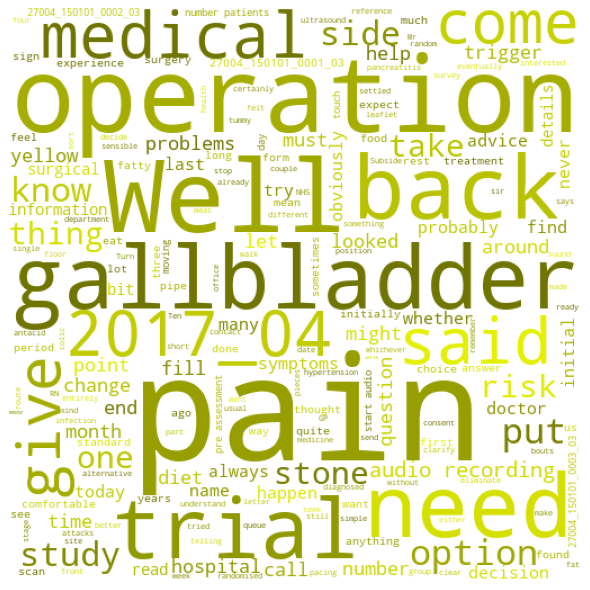

In [4]:
#@title ⠀ {display-mode: "form"}
  

# read the file content
file_content=open ("data/uploaded_file.txt").read()

# create an extra stopwords list where we will add
# all irrelevant words 
# for example researcher and patient (R1, R2, P1, P2) are dominant words but highly irrelevant
stoppwords = ["R1", "R2", "P1", "P2", "ve", "Okay", 'heck', '2017_01', 'overspeaking', 'Thank', "Yeah", "right", "think", "will", "now", "go", "got", "yes", "fine", "say", "going"]


def random_color_func(word=None, \
                      font_size=None, \
                      position=None, \
                      orientation=None, \
                      font_path=None, \
                      random_state=None):
  
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


# plot the wordcloud and save it to the directory 
wordcloud = WordCloud(
                            stopwords = stoppwords + list(STOPWORDS),
                            background_color = 'white',
                            color_func = random_color_func,
                            width = 512, height = 512
                      
                            ).generate(file_content)
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.savefig('word_cloud.png') # will be used for reference
plt.show()

## Step 4 - Generate a Topic Model
* The model is finetuned
* The model can be further improved if coherence is too low
* N of topics set to 10


In [10]:
#@title ⠀ {display-mode: "form"}

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 's'])

# Import Dataset
df = pd.read_csv('/content/data/uploaded_file.txt', sep='\t')
#print(df.target_names.unique())
#df.head()

# testing

#print(df.columns)
# returns R - Researcher and P - Participant which are not great names for columns
# df.columns[0]
# needs renaming to CONTENT
col_name = df.columns[0]
df=df.rename(columns = {col_name:'content'})
# testing
# df.columns[0]
# returns content now


# DATA CLEANING STEP
#
#
# Convert to list
data = df.content.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', token) for token in data]

# Remove distracting single quotes
data = [re.sub("\'", "", token) for token in data]

# remove text in square brackets like [surgeon], [name]
data = [re.sub('\[.*?\]', '', token) for token in data]

# remove numbers
data = [re.sub('\w*\d\w*', '', token) for token in data]

# remove punctuation
# might not be necessary now / we can do it later
# data = [re.sub('[%s]' % re.escape(string.punctuation), '', token) for token in data]

# all to lower
data = [word.lower() for word in data]

# filter out short tokens like P and R and i
# neccessary?
#data = [re.sub(r'\b\w{1,1}\b', '', token) for token in data]



# Let’s tokenize each sentence into a list of words
# removing punctuations and unnecessary characters altogether
# on this step

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

# this does not work so good as the words
# gallblader surgery
# laporscopic cholefcystemy
# or any of that kind do not really appear often
# maybe mentioned once

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:5])
# # # # # # # # # #
# # # # # # # # # 
## # # # # # 
##
#

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:5])

# words really are not repeated that often :/
# maximum of two repetitions in the first sentence
# that is why I added would 5 times at index 1
# print(corpus[1])

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

# # # # # # # # # # # # # # # # #
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=111, #fine tuned
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1, #fine tuned
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
print('\n\nFormed Clusters and the key terms that define them:\n\n\n')
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")




Formed Clusters and the key terms that define them:



[(0,
  '0.042*"get" + 0.037*"long" + 0.031*"hypertension" + 0.031*"contact" + '
  '0.031*"letter" + 0.028*"time" + 0.025*"call" + 0.016*"ever" + '
  '0.016*"diagnose" + 0.016*"anyway"'),
 (1,
  '0.053*"thank" + 0.041*"change" + 0.029*"choice" + 0.026*"find" + '
  '0.025*"survey" + 0.025*"random" + 0.022*"would" + 0.022*"could" + '
  '0.018*"option" + 0.017*"reference"'),
 (2,
  '0.048*"help" + 0.043*"feel" + 0.033*"problem" + 0.027*"obviously" + '
  '0.027*"risk" + 0.027*"well" + 0.027*"right" + 0.022*"need" + 0.021*"want" + '
  '0.021*"option"'),
 (3,
  '0.051*"medical" + 0.047*"would" + 0.043*"take" + 0.035*"happen" + '
  '0.034*"come" + 0.026*"initial" + 0.026*"probably" + 0.025*"have" + '
  '0.021*"back" + 0.020*"say"'),
 (4,
  '0.068*"let" + 0.051*"back" + 0.022*"already" + 0.018*"may" + 0.018*"food" + '
  '0.018*"eliminate" + 0.018*"eat" + 0.018*"fatty" + 0.014*"say" + '
  '0.013*"pain"'),
 (5,
  '0.039*"sometimes" + 0.031*

In [16]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 15):
    print('\nTopic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))


Topic: 0 
Words: get|long|hypertension|contact|letter|time|call|diagnose|ever|anyway|gps|great|personal|address|ethnicity

Topic: 1 
Words: thank|change|choice|find|survey|random|would|could|option|reference|much|mind|manage|randomised|go

Topic: 2 
Words: help|feel|problem|obviously|risk|well|right|need|want|option|chance|super|leaflet|send|affect

Topic: 3 
Words: medical|would|take|happen|come|initial|probably|have|back|say|s|gallbladder|put|study|be

Topic: 4 
Words: let|back|already|may|food|eliminate|eat|fatty|say|pain|lot|trigger|find|end|never

Topic: 5 
Words: sometimes|remember|health|rest|still|doctor|surname|have|month|many|pain|attack|medical|try|think

Topic: 6 
Words: information|read|side|need|day|be|quite|sign|moment|carbon|press|copy|hard|operation|gallbladder

Topic: 7 
Words: back|office|last|would|call|short|nee|sure|term|hold|lady|run|speak|strong|page

Topic: 8 
Words: have|number|fill|trial|make|say|thought|would|decision|operation|standard|settle|want|see|pain

It is good to check the perplexity and coherence scores with the fine-tuned model to check if further fine-tuning is needed.

In [ ]:
#@title ⠀ {display-mode: "form"}


# visualize and check perplexity and coherence score
# Compute Perplexity
print('The overall coherence score of a topic is the average of the distances between words.')
print('.3 is bad\n.4 is low\n.55 and above is good')
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Step 5 - Generate models to find the one with highest coherence
* Run this cell
* It will generate 7 models and plot their coxerence
* This will help the user decide how many topics to use for their model


In [ ]:
#@title ⠀ {display-mode: "form"}


# find optimal number of topics for highest coherence
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

    #coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('lda_models.png')
plt.show()

## Step 6 - Ask Questions
* choose questions that are relevant to the word cloud / topics
* starting with Randomisation



In [ ]:
#@title ⠀ {display-mode: "form"}
import re
import random

# best performing model for our QA
name = 'distilbert-base-cased-distilled-squad'

tokenizer = AutoTokenizer.from_pretrained(name,)
model = AutoModelForQuestionAnswering.from_pretrained(name)

# init inference pipeline 
nlp = pipeline('question-answering', model = model, tokenizer = tokenizer)


controller_varx = 0

def user_xperience():



  # UI
  print('Due to size of context, answers take time to load.\n\n')

  ### RANDOMISATION PART
  ###
  ###
  ###
  ###


  w = widgets.Dropdown(
      options=['What are you randomised for?','What are you allocated for?', 'What does the computer decide?', 'Who makes the decision?', 'What is randomisation?'],
      value=None,
      description='Q1:',
  )

  def on_change(change):


      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
              
          def transcriptName():


            global controller_varx # global variable


            # best terms for the randomisation paraphrases
            # evaluation done through testing on all transcripts
            best_terms_randomisation = ['whether', 'surgery', 'medical', 'management', 'keep an eye', 'allocated', 'what treatment', 'dietary advice', 'painkillers', 'blindly allocate', 'wait and see','having', 'which arm', 'which', 'surgery', 'no surgery', 'no operation', 'flipping the coin', 'pathway', ]

            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 
              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')

              # call to pipeline
              result = (nlp({
                'question': surgery_question,
                'context': data}))
              print('Question: ', surgery_question)

              # pretty print
              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']

              # regex check for matching answers
              match = re.compile('|'.join(best_terms_randomisation), re.IGNORECASE).findall(z)

              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                

              if counter >= 3:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')

                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 2:
                print('\nNum of relevant keywords: ', counter, '(medium)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(low)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")
              
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #print("Answers: ", controller_varx, "/6")
              
          transcriptName()


  w.observe(on_change)
  display(w)

  ### MEDICAL REASONING PART
  ###
  ###
  ###
  ###

  x = widgets.Dropdown(
      
      options=['Does surgery cure pain?', \
              'What is the best way to treat gallstones? ', 'What is the reason for doing the trial?' , \
              'What is the initial outset?','What is the best treatment?',\
              'Is one treatment better than the other?', 'Is surgery the way to go?',\
              'Is operation the way to go?', 'Does having an operation cure?'],

      value=None,
      description='Q2:',
  )


  def on_change(change):


      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
          
              
          def transcriptName():

            global controller_varx # global variable
            
            # best terms for the randomisation paraphrases
            # evaluation done through testing on all transcripts
            best_terms_reasoning = ['better', 'treatment', 'which', 'whether', 'pros', 'cons', 'not one', 'should', 'know', 'need', 'safer', 'symptomatic', 'pain', 'after', 'surgery', 'predict']
            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 

              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')


              result = (nlp({
                'question': surgery_question,
                'context': data}))
              print('Question: ', surgery_question)

              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']
              match = re.compile('|'.join(best_terms_reasoning), re.IGNORECASE).findall(z)
              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                
                
                
              if counter >= 3:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')

                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 2:
                print('\nNum of relevant keywords: ', counter, '(medium)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(low)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")
              
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #print("Answers: ", controller_varx, "/6")
                #print("Answers: ", controller_varx, "/6")
          # borders

          


          transcriptName()


  x.observe(on_change)
  display(x)

  ### BOTH ARMS DISCUSSION
  ###
  ###
  ###
  ###

  y = widgets.Dropdown(
      options=['What is medical management?', 'What is conservative management?', 'What is the surgery called?', 'What is the surgery?'],
      value=None,
      description='Q3:',
  )


  def on_change(change):

      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
          
              
          def transcriptName():

            # best terms for the arms paraphrases
            # evaluation done through testing on all transcripts
            best_terms_arms = ['advice', 'diet', 'painkillers', 'keyhole', 'surgery', 'anasthesia', 'paracetamol', 'codeine', 'watchful waiting', 'no surgery', 'laparoscopic', 'cholecystectomy']
            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 

              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')

              print('Question: ', surgery_question)

              result = (nlp({
                'question': surgery_question,
                'context': data}))

              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']
              match = re.compile('|'.join(best_terms_arms), re.IGNORECASE).findall(z)
              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                
                
                
              if counter >= 3:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')

                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 2:
                print('\nNum of relevant keywords: ', counter, '(medium)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(low)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")
              
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #print("Answers: ", controller_varx, "/6")

          


          transcriptName()


  y.observe(on_change)
  display(y)

  ### RISKS DISCUSSION
  ###
  ###
  ###
  ###

  z = widgets.Dropdown(
      options=['What are the risks of surgery?' , 'What are the risks of operation?', 'Are there any risks?', 'What are the risks?'],
      value=None,
      description='Q4:',
  )


  def on_change(change):


      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
          
          def transcriptName():

            # best terms for the risks paraphrases
            # evaluation done through testing on all transcripts
            best_terms_risks = ['worse', 'bleeding', 'damage',' inside', 'cause', 'problems', 'complications', 'risks', 'associated', 'obstructing', 'liver', 'pancreatitis', 'general', 'anaesthetic', 'scars', 'infection', 'serious', 'advantages', 'disadvantages', 'both', 'attacks', 'episode']
            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 

              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')


              result = (nlp({
                'question': surgery_question,
                'context': data}))
              
              print('Question: ', surgery_question)

              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']
              match = re.compile('|'.join(best_terms_risks), re.IGNORECASE).findall(z)
              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                
                
                
              if counter >= 3:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')

                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 2:
                print('\nNum of relevant keywords: ', counter, '(medium)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")

              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(low)')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #controller_varx = controller_varx + 1
                #print("Answers: ", controller_varx, "/6")
              
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
                #controller_varx = 0
                #print("Answers: ", controller_varx, "/6")

          


          transcriptName()


  z.observe(on_change)
  display(z)

  ### QUESTIONNAIRE / FOLLOW-UP DISCUSSION
  ###
  ###
  ###
  ###
  g = widgets.Dropdown(
      options=['Will you be receiving questionnaires?', 'What are the follow up procedures?', 'Will you follow up?', 'Will you fill the questonnaires?'],
      value=None,
      description='Q5:',
  )


  def on_change(change):

      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
          
          def transcriptName():

            # best terms for the arms paraphrases
            # evaluation done through testing on all transcripts
            best_terms_followup = ['questionnaire', 'questionnaires', 'call', 'follow-up', 'come', 'back', 'carry', 'read', 'sent', 'contacted', '3', '6', '12', 'months', 'patient']
            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 

              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')

              result = (nlp({
                'question': surgery_question,
                'context': data}))
              
              print('Question: ', surgery_question)

              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']
              match = re.compile('|'.join(best_terms_followup), re.IGNORECASE).findall(z)
              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                
                
                
              if counter >= 2:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')
              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(moderate)')
                print('- - - - - - - - - - - - - - - - - - - -')
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
          # borders
          


          transcriptName()


  g.observe(on_change)
  display(g)

  ### CONSENT
  ###
  ###
  ###
  ###

  b = widgets.Dropdown(
      options=['Are you happy with all that?', 'Are you happy with the answers?', 'Are you happy to consent?', \
              'Do you want to go for surgery straight away?','Do you want to think about it', 'Are you ready to make a decision?', 'Which route do you want to go?', 'Do you want to go for surgery?', 'What do you want to go for?'],
      value=None,
      description='Q6:',
  )


  def on_change(change):

      if change['type'] == 'change' and change['name'] == 'value':
          surgery_question = change['new']
          
              
          def transcriptName():

            # best terms for the arms paraphrases
            # evaluation done through testing on all transcripts
            best_terms_consent = ['happy', 'make', 'decision', 'consent', 'ahead', 'consented', 'good', 'form', 'forms', 'with', 'information', 'given', 'sign', 'signing', 'yourself', 'fill', 'consenting', 'included', 'trial']
            counter = 0

            with open('data/uploaded_file.txt', 'r') as myfile: 

              next(myfile)
              data=myfile.read().replace('\n', '')

              # UI
              print('- - - - - - - - - - - - - - - - - - - -')
              print('Computing...\n')

              result = (nlp({
                'question': surgery_question,
                'context': data}))
              
              print('Question: ', surgery_question)

              print(f"Answer: '{result['answer']}', \nscore: {round(result['score'], 4)}, \nstart on char n: {result['start']}, end on char n: {result['end']}\n")

              z = result['answer']
              match = re.compile('|'.join(best_terms_consent), re.IGNORECASE).findall(z)
              if match:
                print('Found terms: ', ', '.join(match))
                for matches in match:
                  counter +=1
                
              if counter >= 2:
                print('\nNum of relevant keywords: ', counter, '(high)')
                print('- - - - - - - - - - - - - - - - - - - -')
              elif counter == 1:
                print('\nNum of relevant keywords: ', counter, '(moderate)')
                print('- - - - - - - - - - - - - - - - - - - -')
              else:
                print('\nNo good terms were found. Needs human judgement.\n')
                print('- - - - - - - - - - - - - - - - - - - -')
          # borders

          


          transcriptName()


  b.observe(on_change)
  display(b)



user_xperience()

## Step 7 - Check textual entailment, contradiction and neutrality




In [ ]:
#@title ⠀ {display-mode: "form"}

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/decomposable-attention-elmo-2020.04.09.tar.gz")

x = predictor.predict(
    premise=input('Premise: '), 
    hypothesis=input('Hypothesis: ')
)

x['label_probs'] # entailment, contradiciton, neutral